# Evaluate CLIP on Test Dataset

- Got inspiration for finteuning here: 
    - https://github.com/sachinruk/blog/blob/master/_notebooks/2021-03-07-CLIP.ipynb
    - https://github.com/huggingface/transformers/blob/main/examples/pytorch/contrastive-image-text/run_clip.py


In [2]:
# you might want to restart the kernel after installation is complete.
!pip install transformers evaluate pillow datasets pycm ipywidgets jupyter evaluate jupyter_client --upgrade --quiet

## 1. Getting Dataset

In [3]:
from datasets import load_dataset

In [4]:
test_dataset = load_dataset("vincentclaes/emoji-predictor", split="test")
test_dataset

Using custom data configuration vincentclaes--emoji-predictor-84ee9ecf6ec78809
Reusing dataset parquet (/root/.cache/huggingface/datasets/vincentclaes___parquet/vincentclaes--emoji-predictor-84ee9ecf6ec78809/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Dataset({
    features: ['text', 'label'],
    num_rows: 3736
})

In [5]:
from PIL import Image

no_features = list(set(test_dataset["label"])) # these are the emoji's we use
emojis_as_images = [Image.open(f"emojis/{i}.png") for i in no_features]

## 2. Evaluate Test Dataset

In [6]:
from transformers import CLIPProcessor, CLIPModel
import torch

In [7]:
def evaluate_on_test_dataset(checkpoint, no_suggestions=4):
    print(f"checkpoint used: {checkpoint}")
    checkpoint = checkpoint
    predictions = []
    suggestions = []
    references = []
    SHARDS = 20
    K = no_suggestions

    # not fully understanding this, but with torch.no_grad
    # our GPU does not run out of memory.
    with torch.no_grad():
        for i in range(SHARDS):
            chunk = test_dataset.shard(num_shards=SHARDS, index=i)
            chunk_text = chunk["text"]
            chunk_label = chunk["label"]
            model = CLIPModel.from_pretrained(checkpoint).to("cuda")
            processor = CLIPProcessor.from_pretrained(checkpoint)
            inputs = processor(text=chunk_text, images=emojis_as_images, return_tensors="pt", padding=True, truncation=True)
            outputs = model(**inputs.to("cuda"))
            # we want the probability for each emoji per sentence.
            logits_per_text = outputs.logits_per_text
            # we take the softmax to get the label probabilities
            probs = logits_per_text.softmax(dim=1)

            # take the predictions with the highest probability
            predictions_for_chunk = [torch.argmax(prob).item() for prob in probs]

            # top K number of options
            predictions_suggestions_for_chunk = [torch.topk(prob, K).indices.tolist() for prob in probs]
            # if the label is in the suggestions, take the label else take the first predicted one.
            predictions_suggestions_for_chunk = [x if x in predictions_suggestions_for_chunk[i] else predictions_suggestions_for_chunk[i][0] for i,x in enumerate(chunk_label)]    

            suggestions.extend(predictions_suggestions_for_chunk)
            predictions.extend(predictions_for_chunk)
            references.extend(chunk_label)

            print(f"total predictions so far: {len(predictions)}")
            torch.cuda.empty_cache()
    return {"references": references, "predictions": predictions, "suggestions": suggestions}

_range = [5, 10, 25, 50, 100, 250, 500]
evaluate_dict = {}

for i in _range:
    print(f"> going for few shot: {i}")
    from pathlib import Path
    checkpoints = [str(path).split("checkpoint-")[1] for path in Path(f"./checkpoints-{i}/").iterdir() if "checkpoint-" in str(path)]
    checkpoints.sort(key=int)
    last_checkpoint = checkpoints[-1]
    print(f"> last checkpoint: {last_checkpoint}")
    results = evaluate_on_test_dataset(checkpoint=f"./checkpoints-{i}/checkpoint-{last_checkpoint}")
    evaluate_dict[i] = results
    

> going for few shot: 5
> last checkpoint: 16
checkpoint used: ./checkpoints-5/checkpoint-16


/opt/conda/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


total predictions so far: 187
total predictions so far: 374
total predictions so far: 561
total predictions so far: 748
total predictions so far: 935
total predictions so far: 1122
total predictions so far: 1309
total predictions so far: 1496
total predictions so far: 1683
total predictions so far: 1870
total predictions so far: 2057
total predictions so far: 2244
total predictions so far: 2431
total predictions so far: 2618
total predictions so far: 2805
total predictions so far: 2992
total predictions so far: 3178
total predictions so far: 3364
total predictions so far: 3550
total predictions so far: 3736
> going for few shot: 10
> last checkpoint: 28
checkpoint used: ./checkpoints-10/checkpoint-28
total predictions so far: 187
total predictions so far: 374
total predictions so far: 561
total predictions so far: 748
total predictions so far: 935
total predictions so far: 1122
total predictions so far: 1309
total predictions so far: 1496
total predictions so far: 1683
total prediction

## 4. Evaluate Few Shot.

In [8]:

def evaluate_precision(references, predictions):
    import evaluate
    precision_metric = evaluate.load("precision")
    print("""We calculate the precision for prediction the right emoji. 
    The following number show the percentage of correctly predicted (TP) 
    compared to wrongly + correctly predcted (FP + TP). \n""")

    # Micro-averaging will put more emphasis on the common classes in the data set. 
    # Rare labels shouldn’t influence the overall precision metric heavily.
    precision_for_predictions = precision_metric.compute(references=references, predictions=predictions, average="micro")
    print("Precision for the emoji with highest probability:")
    print(precision_for_predictions)
    

from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def confusion_matrix_emojis(labels, predictions):
    cm = confusion_matrix(labels, predictions)
    # Normalise
    # cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.set(rc={'figure.figsize':(25,25)})
    heatmap = sns.heatmap(cm, annot=True)
    heatmap.set(xlabel='Predicted Labels', ylabel='True Labels')

    img = [plt.imread(f"emojis/{i}.png") for i in no_features]
    tick_labels = heatmap.xaxis.get_ticklabels()
    y_tick_labels = heatmap.yaxis.get_ticklabels()
    for i,im in enumerate(img):
        ib = OffsetImage(im, zoom=.4)
        ib.image.axes = heatmap
        ab_x = AnnotationBbox(ib,
                        tick_labels[i].get_position(),
                        frameon=False,
                        box_alignment=(0.5, 50)
                        )
        ab_y = AnnotationBbox(ib,
                        y_tick_labels[i].get_position(),
                        frameon=False,
                        box_alignment=(3, 0.5)
                        )
        heatmap.add_artist(ab_x)
        heatmap.add_artist(ab_y)

    plt.show(block=False)



In [9]:
# return {"references": references, "predictions": predictions, "suggestions": suggestions}

def evaluate_predictions(i):
    evaluate_precision(references=evaluate_dict[i]["references"], predictions=evaluate_dict[i]["predictions"])
    confusion_matrix_emojis(labels=evaluate_dict[i]["references"], predictions=evaluate_dict[i]["predictions"])
    

def evaluate_suggestions(i):
    evaluate_precision(references=evaluate_dict[i]["references"], predictions=evaluate_dict[i]["suggestions"])
    confusion_matrix_emojis(labels=evaluate_dict[i]["references"], predictions=evaluate_dict[i]["suggestions"])

We calculate the precision for prediction the right emoji. 
    The following number show the percentage of correctly predicted (TP) 
    compared to wrongly + correctly predcted (FP + TP). 

Precision for the emoji with highest probability:
{'precision': 0.11081370449678801}


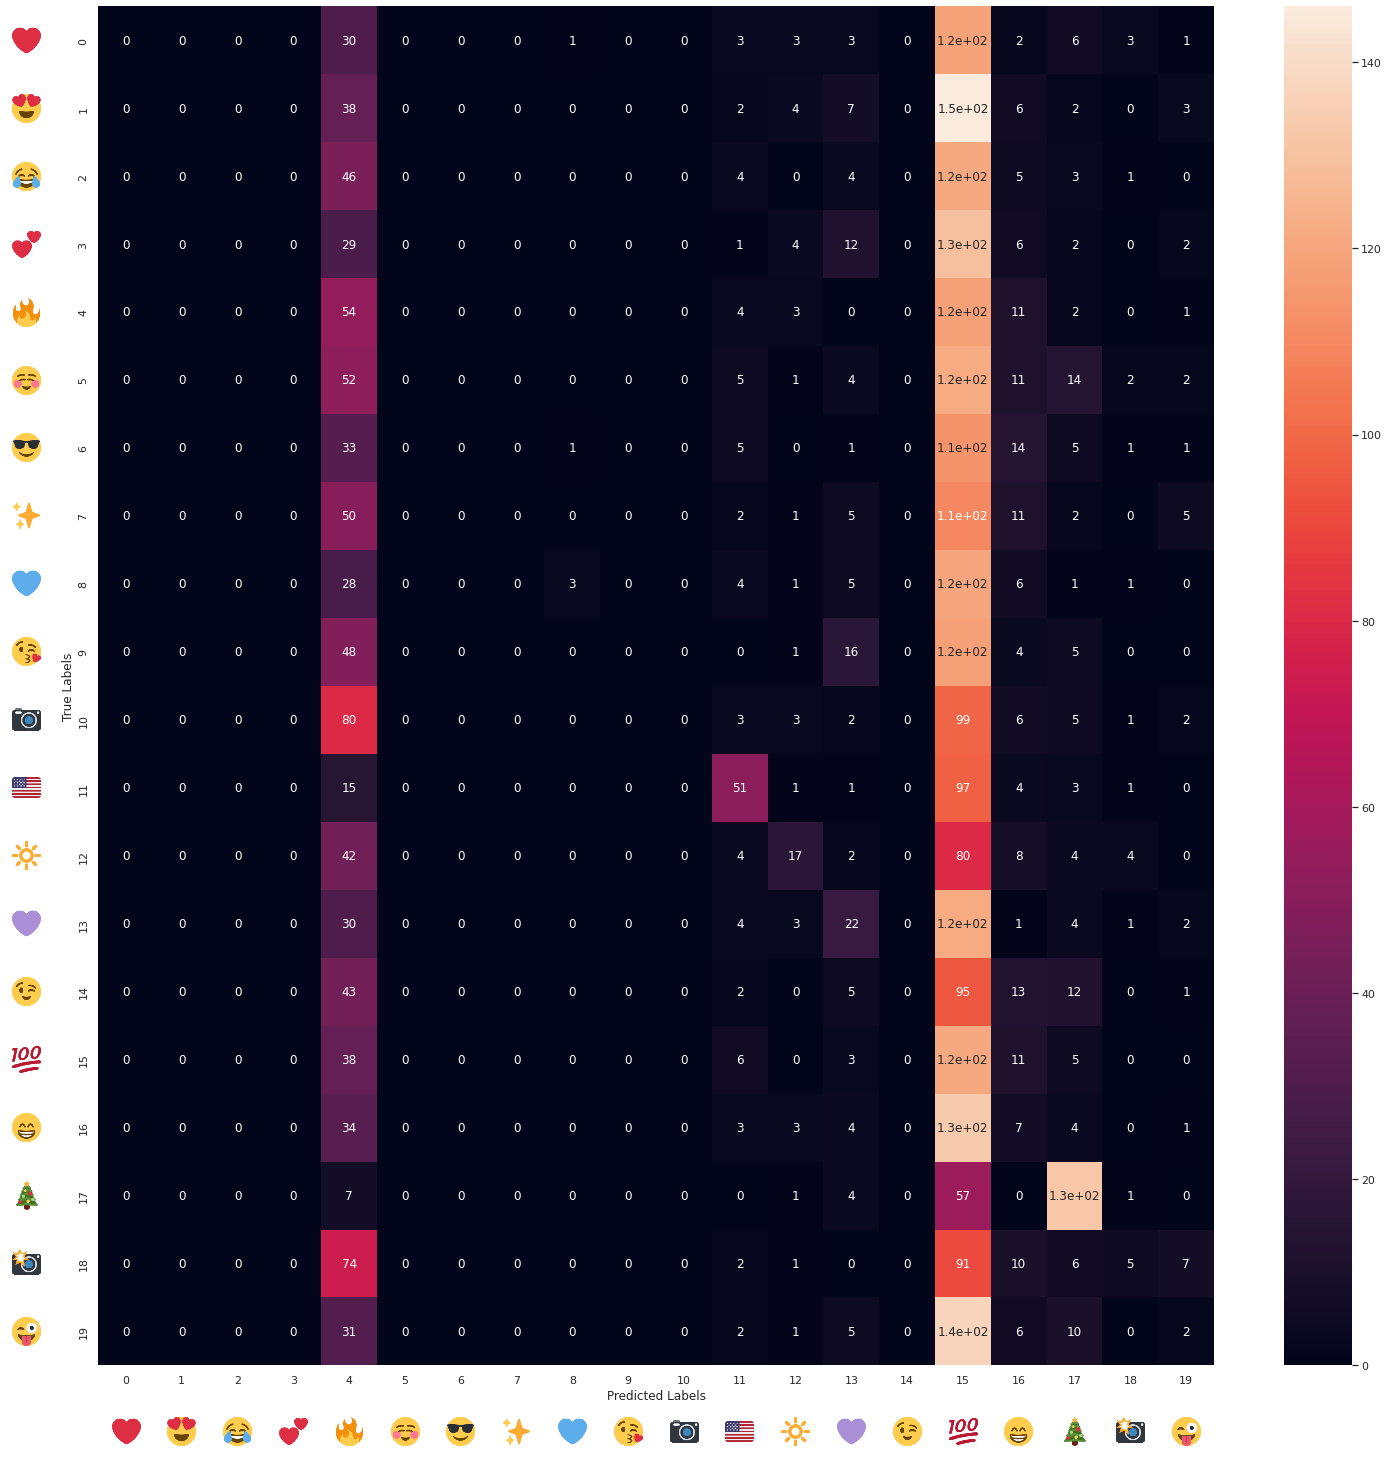

In [16]:
i=5
evaluate_predictions(i=i)

We calculate the precision for prediction the right emoji. 
    The following number show the percentage of correctly predicted (TP) 
    compared to wrongly + correctly predcted (FP + TP). 

Precision for the emoji with highest probability:
{'precision': 0.26900428265524623}


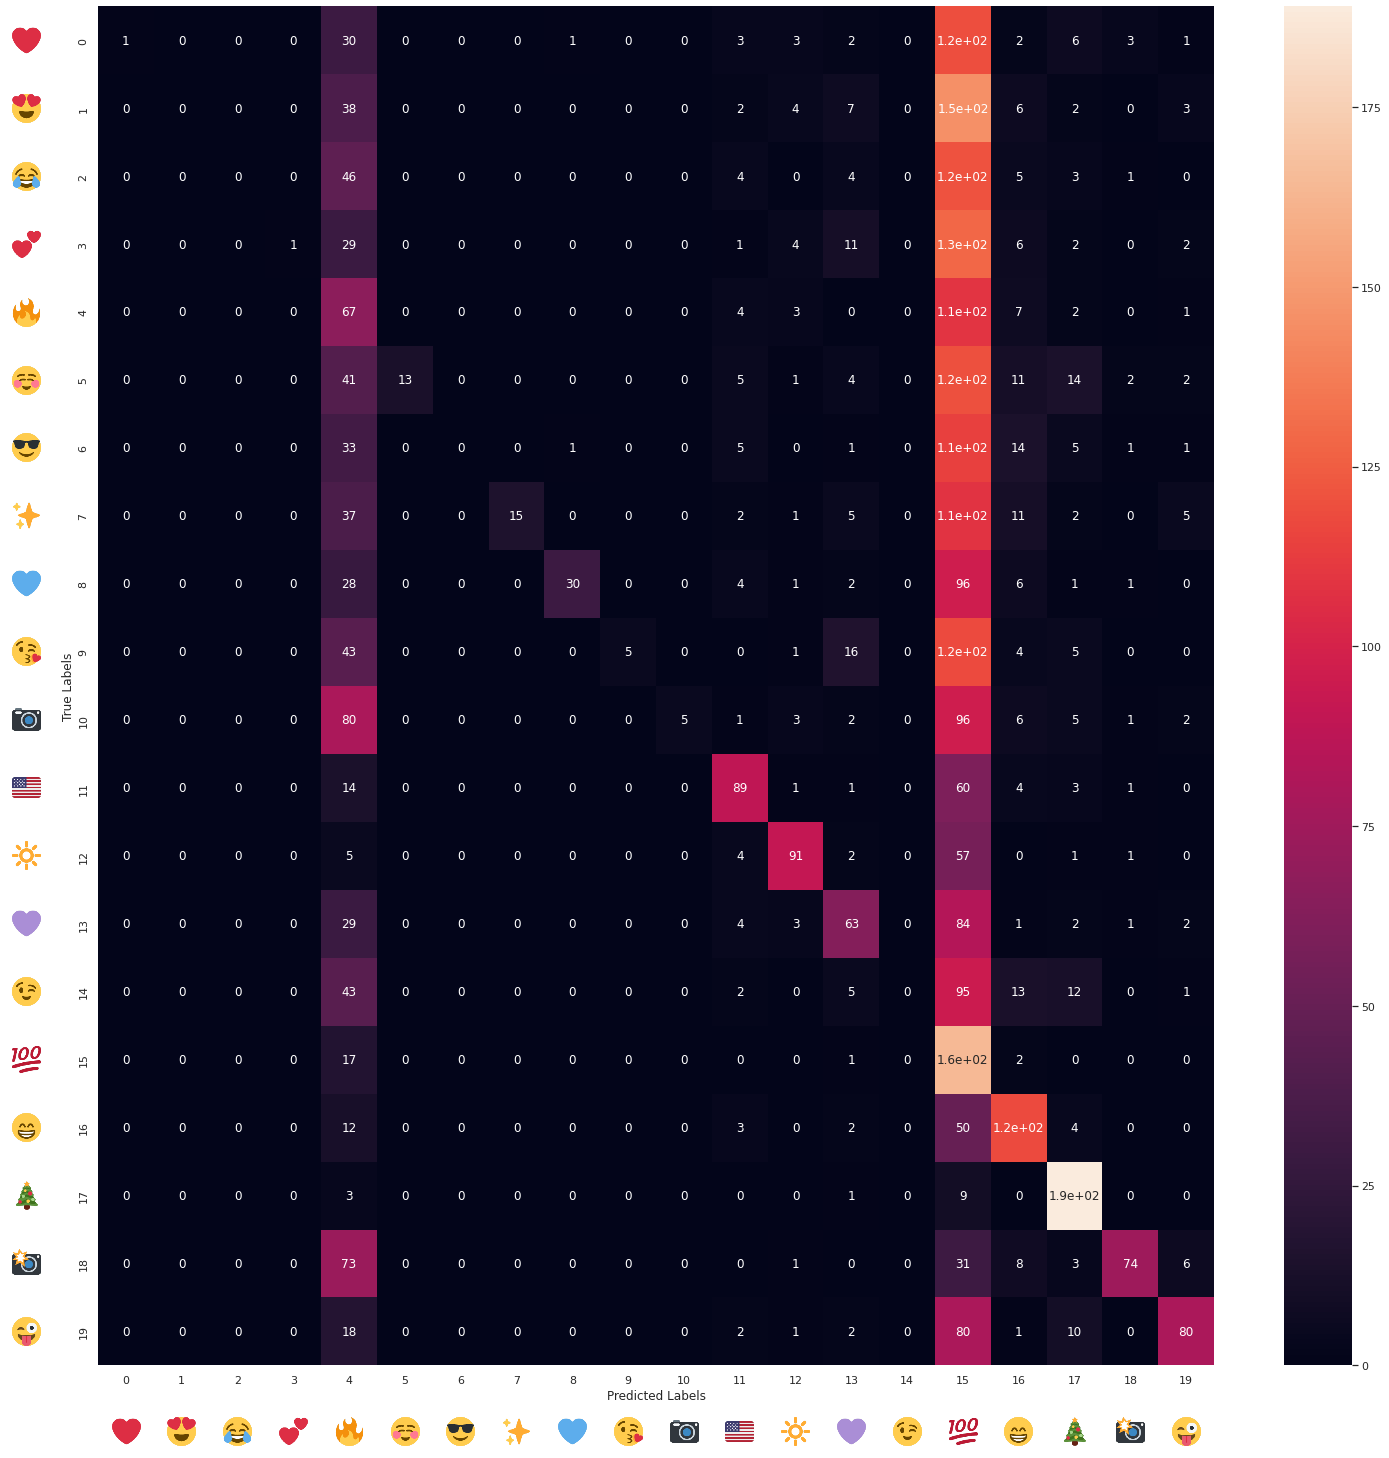

In [17]:
evaluate_suggestions(i=i)

We calculate the precision for prediction the right emoji. 
    The following number show the percentage of correctly predicted (TP) 
    compared to wrongly + correctly predcted (FP + TP). 

Precision for the emoji with highest probability:
{'precision': 0.1670235546038544}


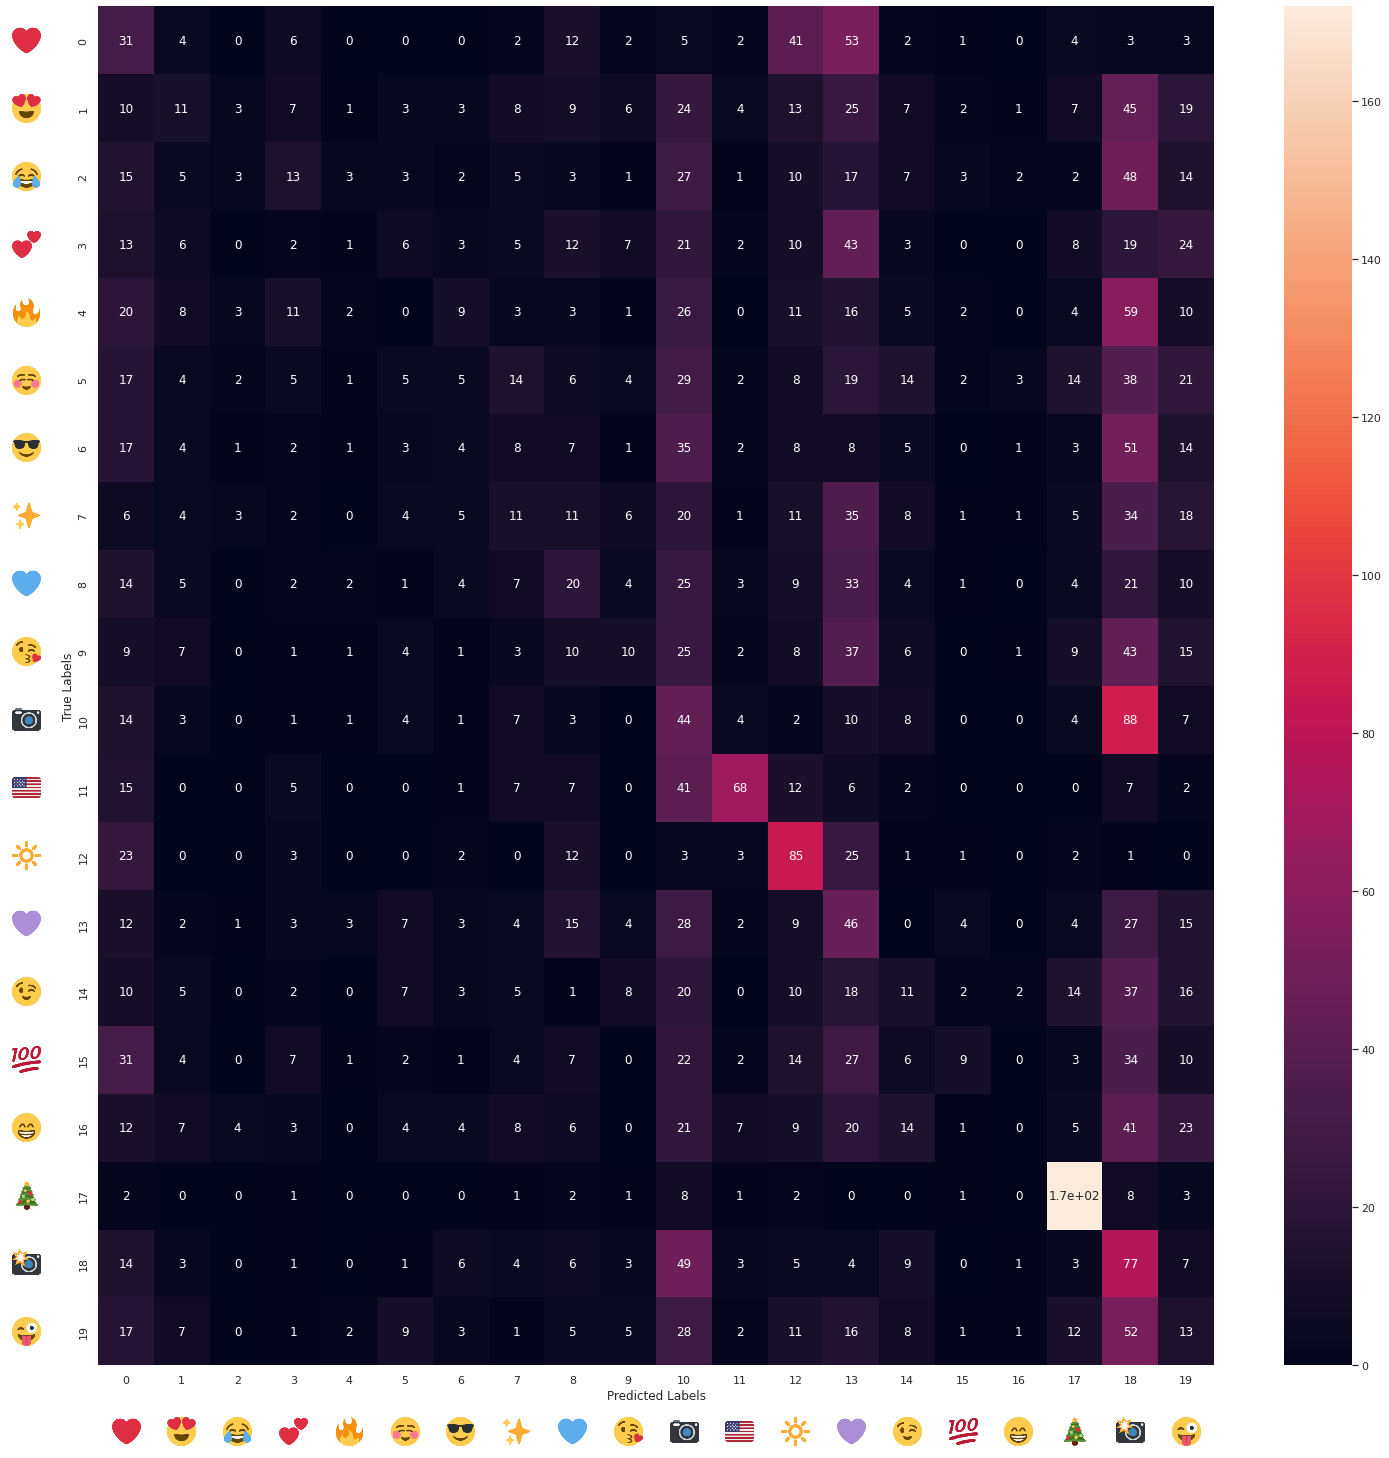

In [18]:
i=10
evaluate_predictions(i=i)

We calculate the precision for prediction the right emoji. 
    The following number show the percentage of correctly predicted (TP) 
    compared to wrongly + correctly predcted (FP + TP). 

Precision for the emoji with highest probability:
{'precision': 0.39079229122055675}


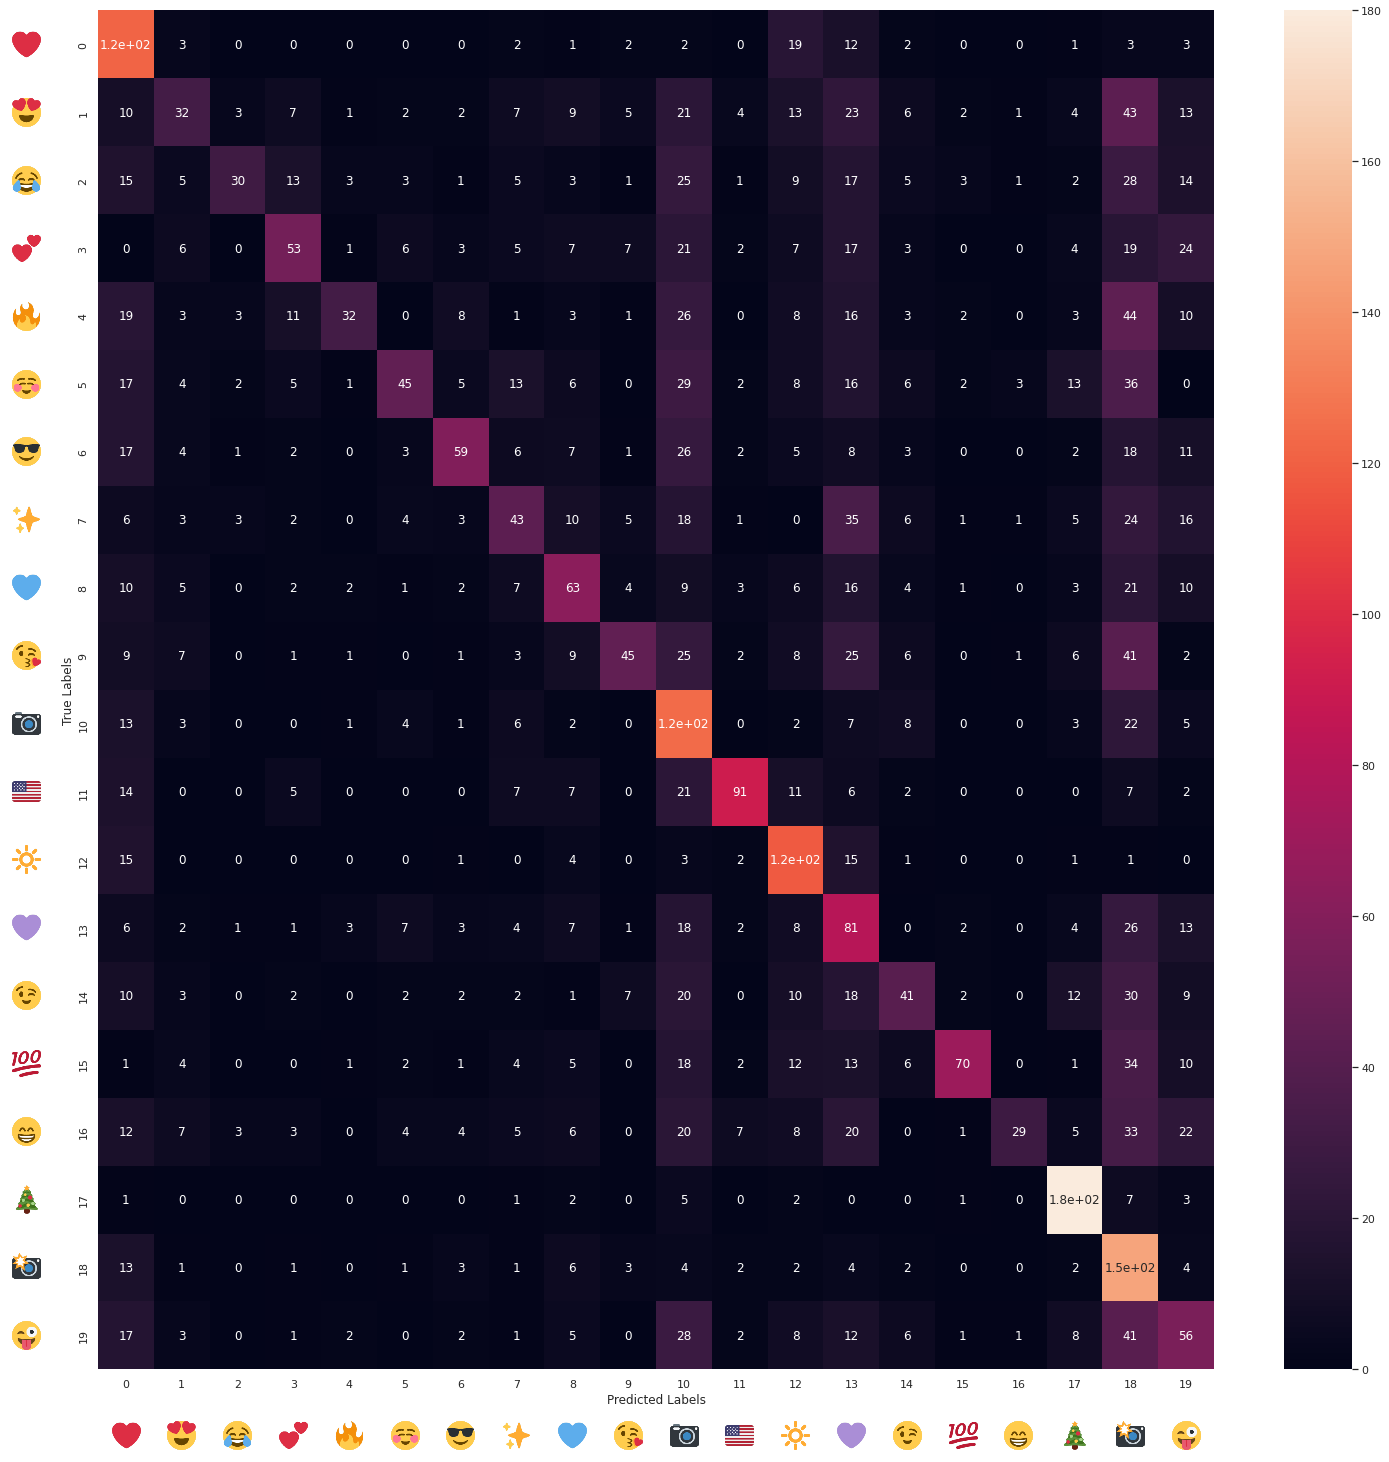

In [19]:
evaluate_suggestions(i=i)

We calculate the precision for prediction the right emoji. 
    The following number show the percentage of correctly predicted (TP) 
    compared to wrongly + correctly predcted (FP + TP). 

Precision for the emoji with highest probability:
{'precision': 0.25133832976445397}


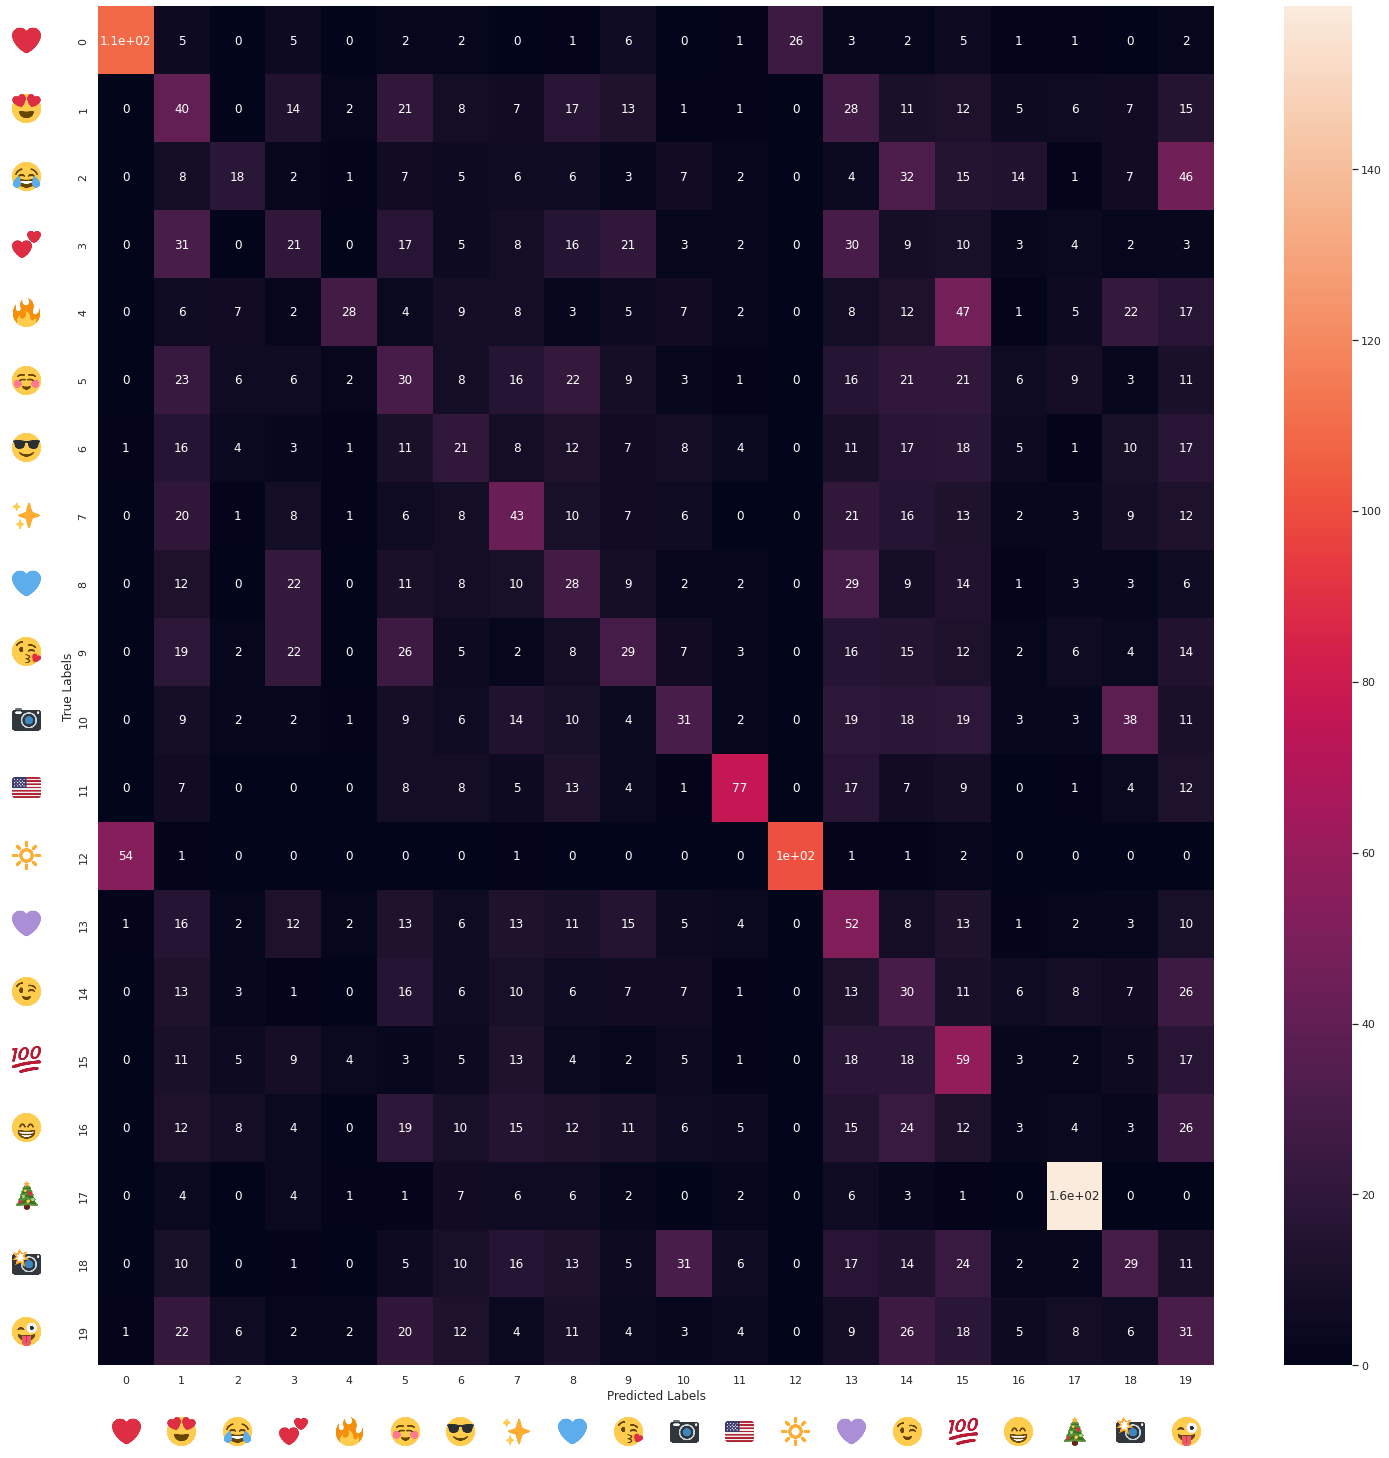

In [20]:
i=25
evaluate_predictions(i=i)

We calculate the precision for prediction the right emoji. 
    The following number show the percentage of correctly predicted (TP) 
    compared to wrongly + correctly predcted (FP + TP). 

Precision for the emoji with highest probability:
{'precision': 0.5289079229122056}


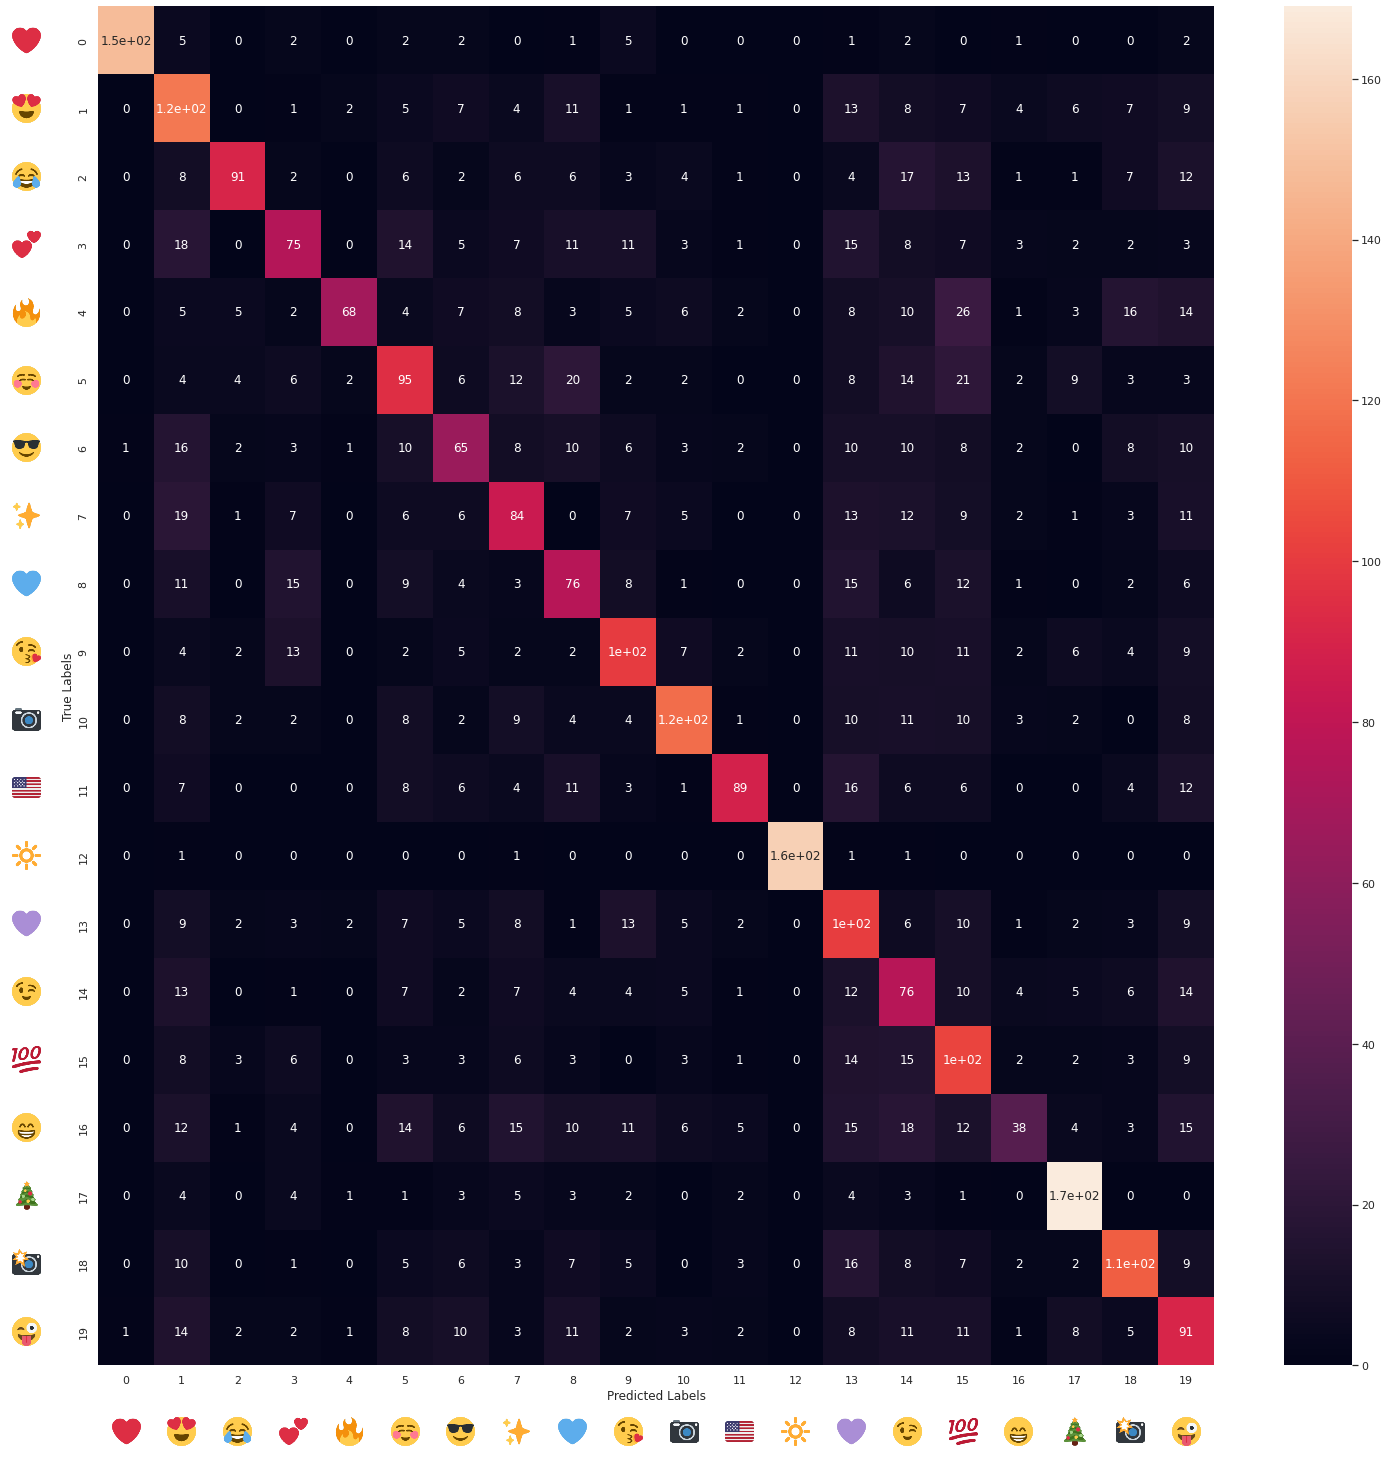

In [21]:
evaluate_suggestions(i=i)

We calculate the precision for prediction the right emoji. 
    The following number show the percentage of correctly predicted (TP) 
    compared to wrongly + correctly predcted (FP + TP). 

Precision for the emoji with highest probability:
{'precision': 0.24866167023554603}


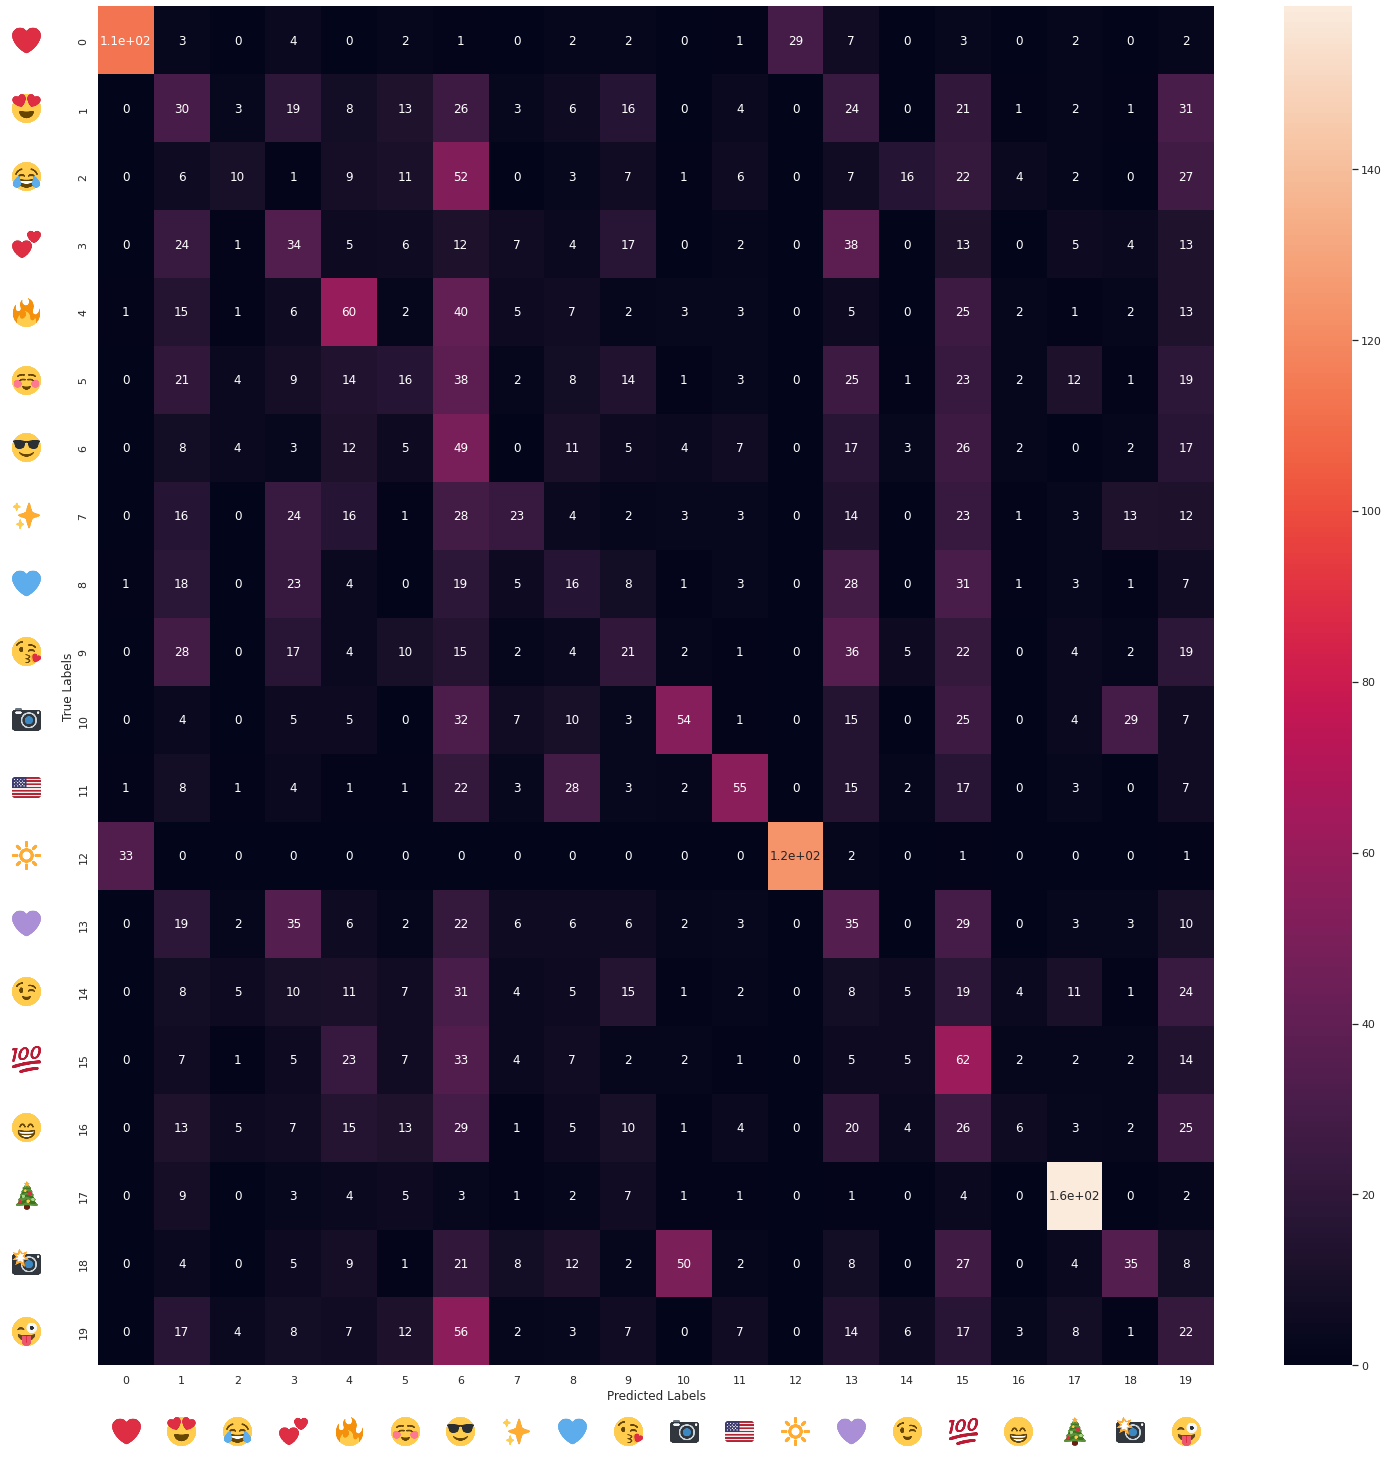

In [22]:
i=50
evaluate_predictions(i=i)

We calculate the precision for prediction the right emoji. 
    The following number show the percentage of correctly predicted (TP) 
    compared to wrongly + correctly predcted (FP + TP). 

Precision for the emoji with highest probability:
{'precision': 0.5168629550321199}


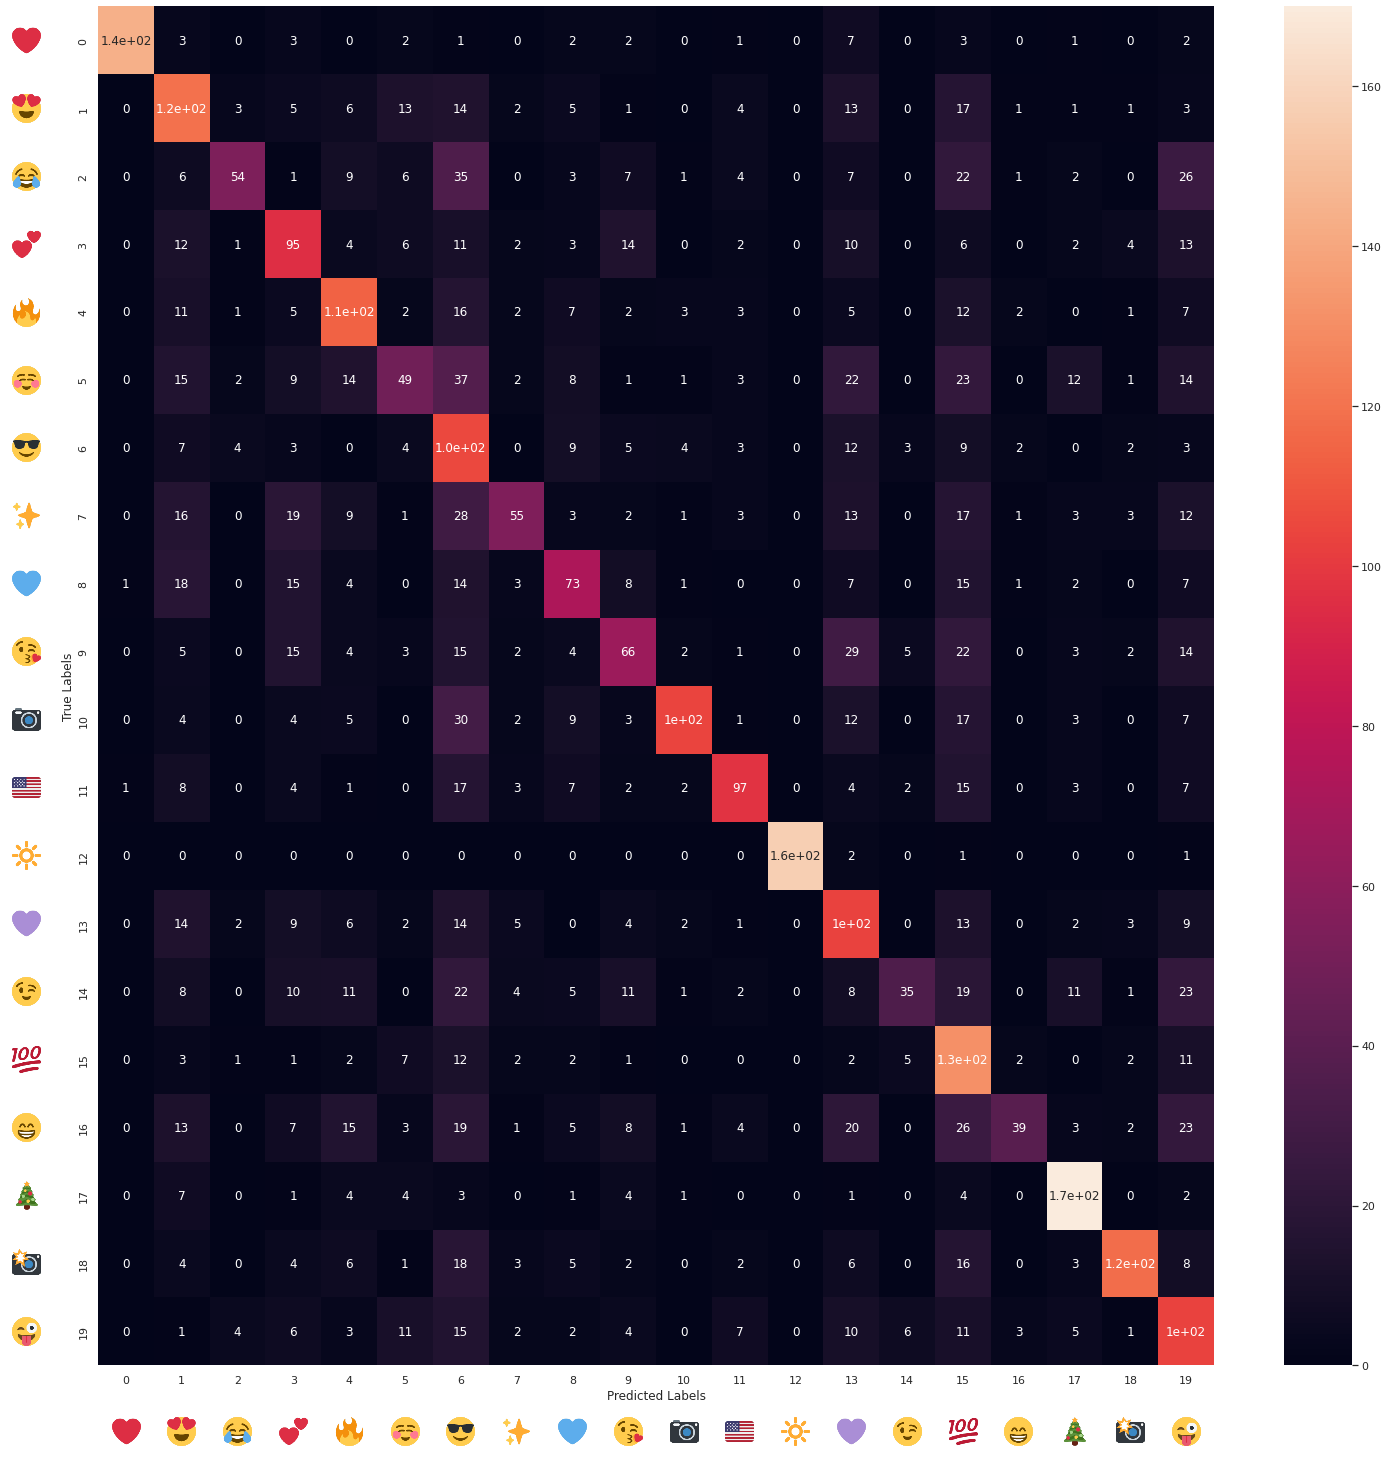

In [23]:
evaluate_suggestions(i=i)

We calculate the precision for prediction the right emoji. 
    The following number show the percentage of correctly predicted (TP) 
    compared to wrongly + correctly predcted (FP + TP). 

Precision for the emoji with highest probability:
{'precision': 0.2874732334047109}


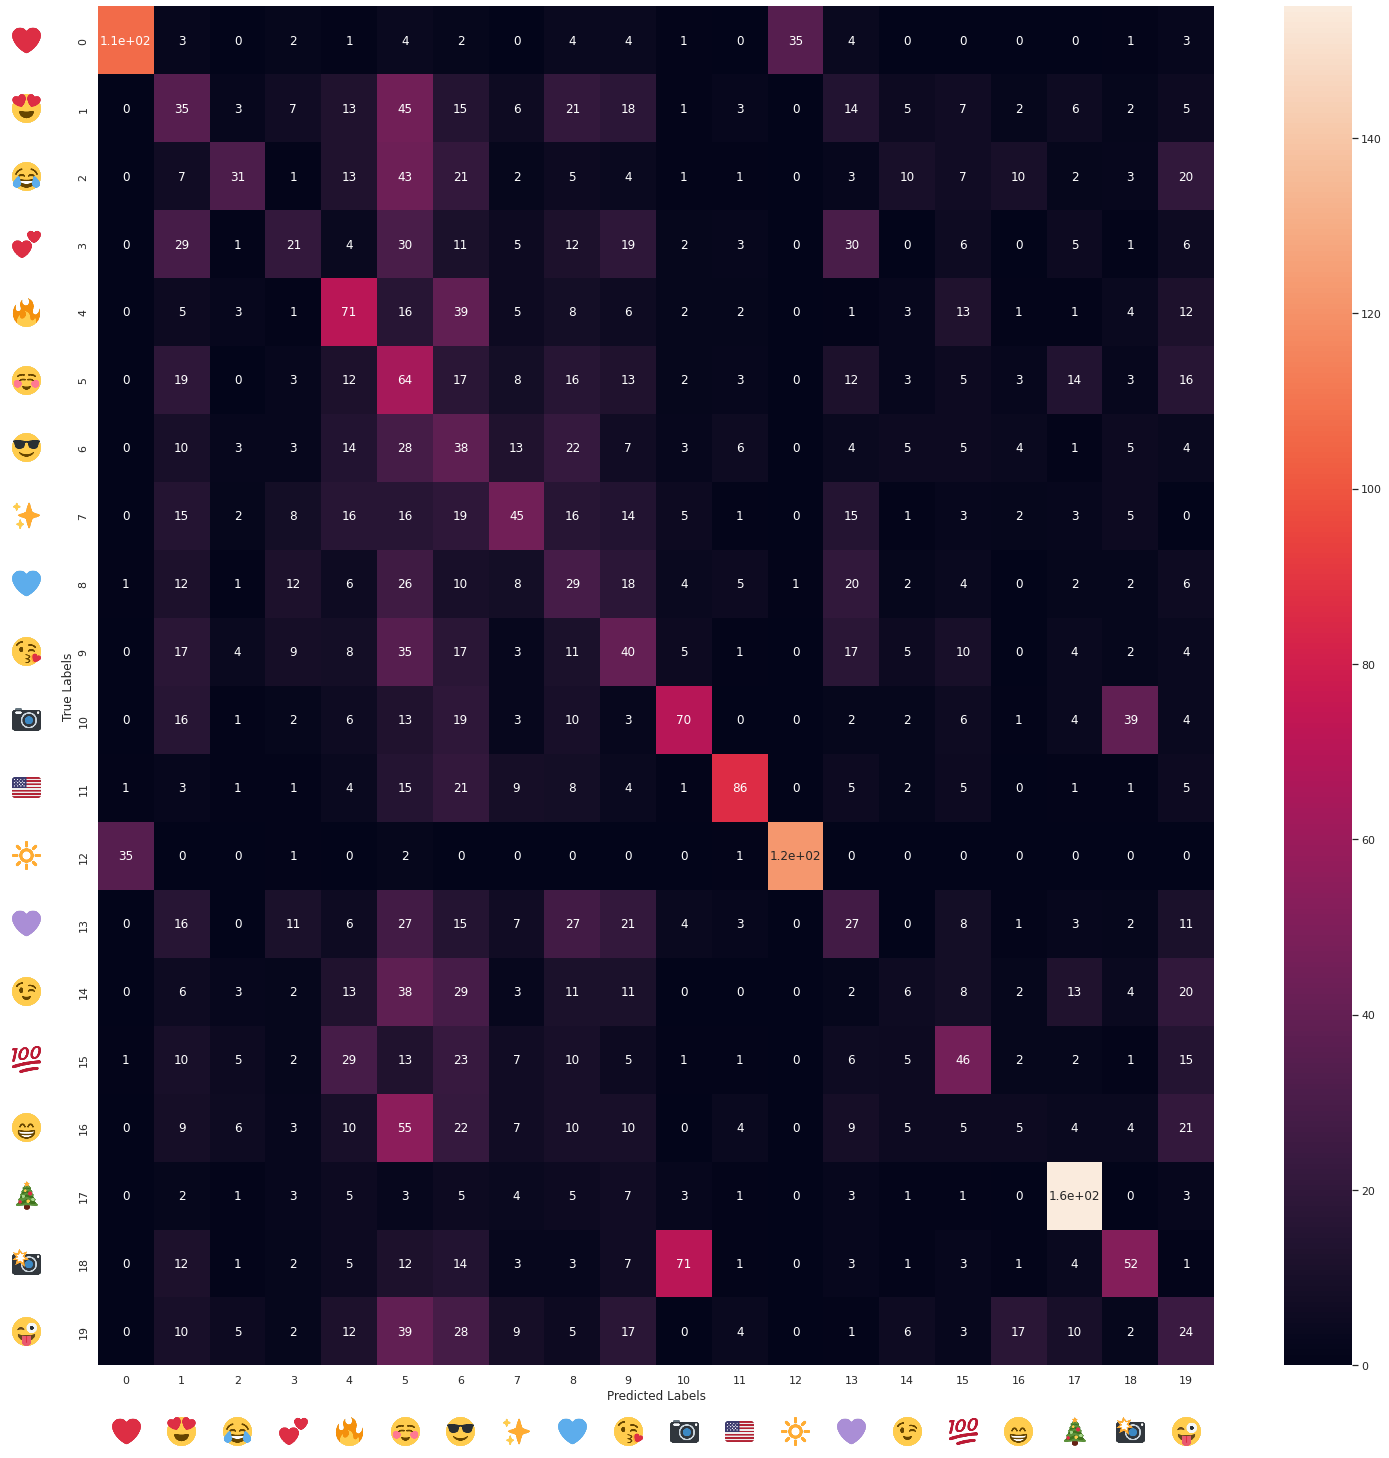

In [24]:
i=100
evaluate_predictions(i=i)

We calculate the precision for prediction the right emoji. 
    The following number show the percentage of correctly predicted (TP) 
    compared to wrongly + correctly predcted (FP + TP). 

Precision for the emoji with highest probability:
{'precision': 0.5752141327623126}


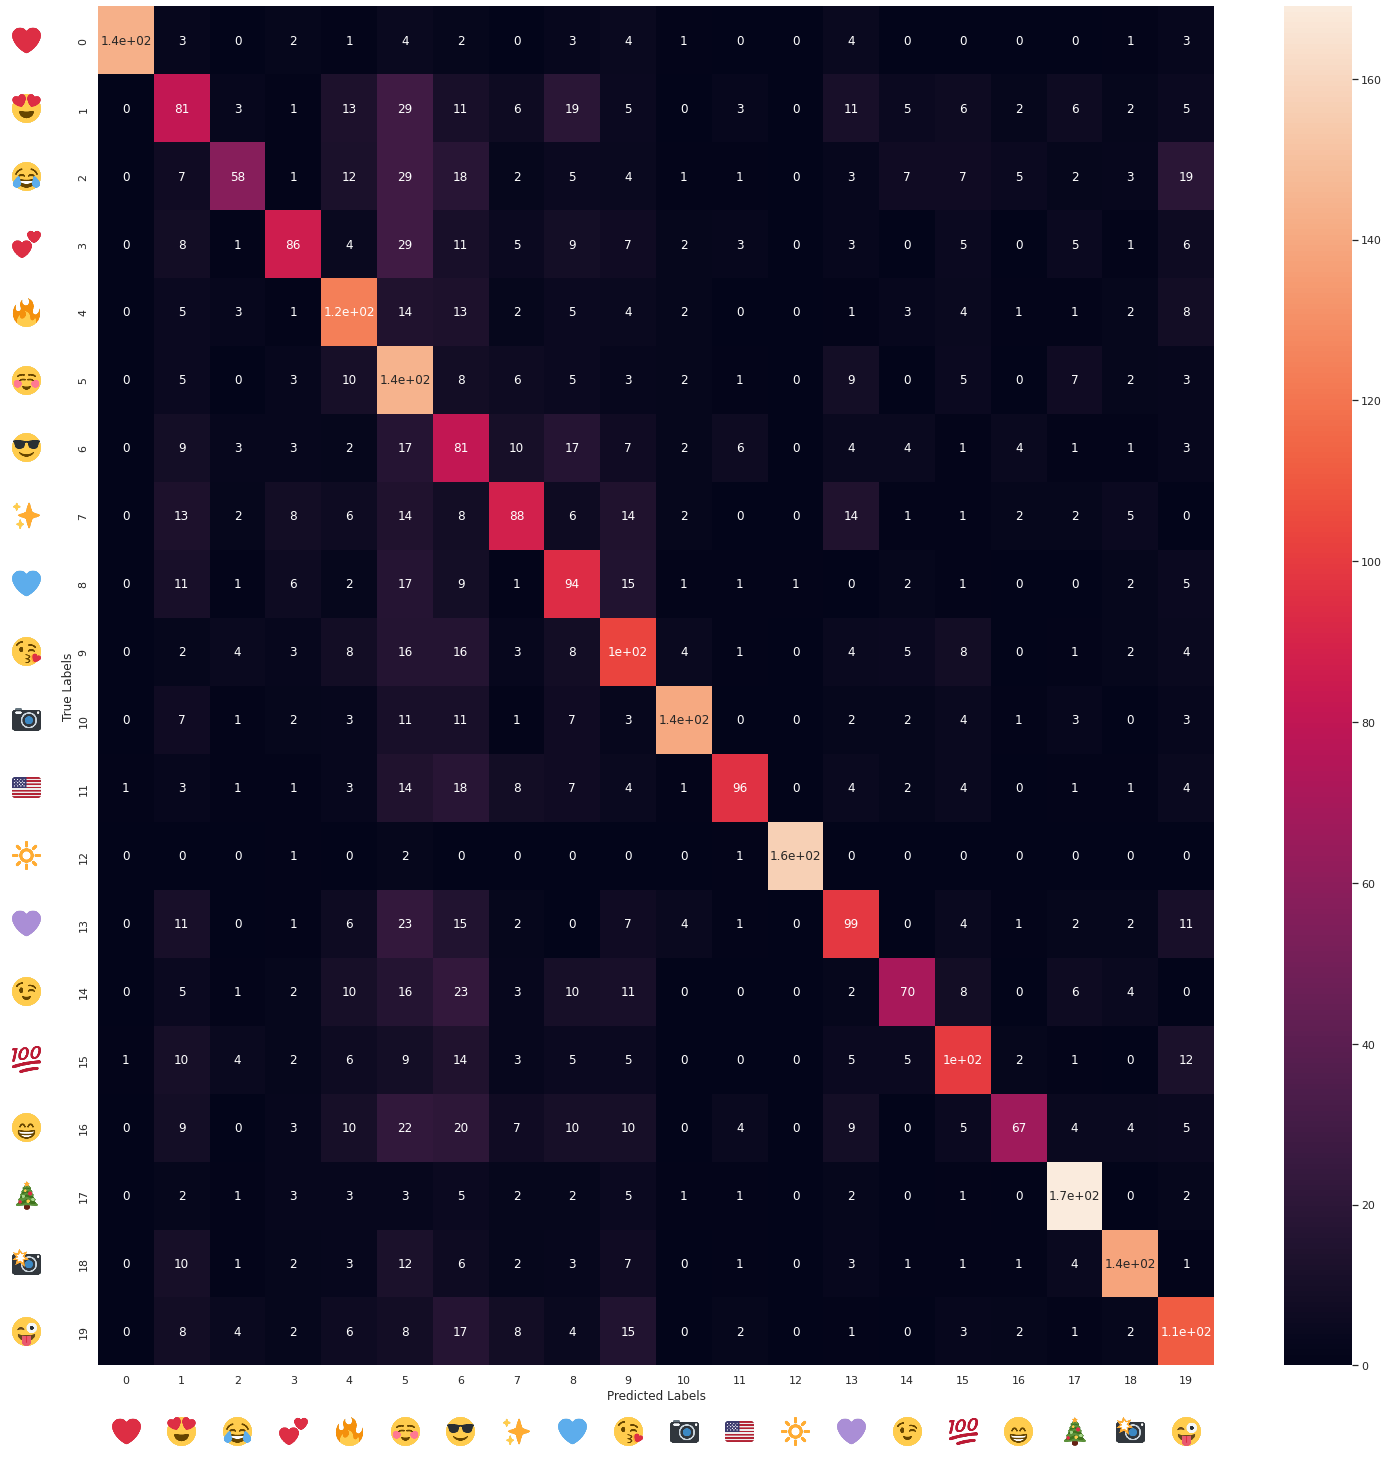

In [25]:
evaluate_suggestions(i=i)

We calculate the precision for prediction the right emoji. 
    The following number show the percentage of correctly predicted (TP) 
    compared to wrongly + correctly predcted (FP + TP). 

Precision for the emoji with highest probability:
{'precision': 0.31397216274089934}


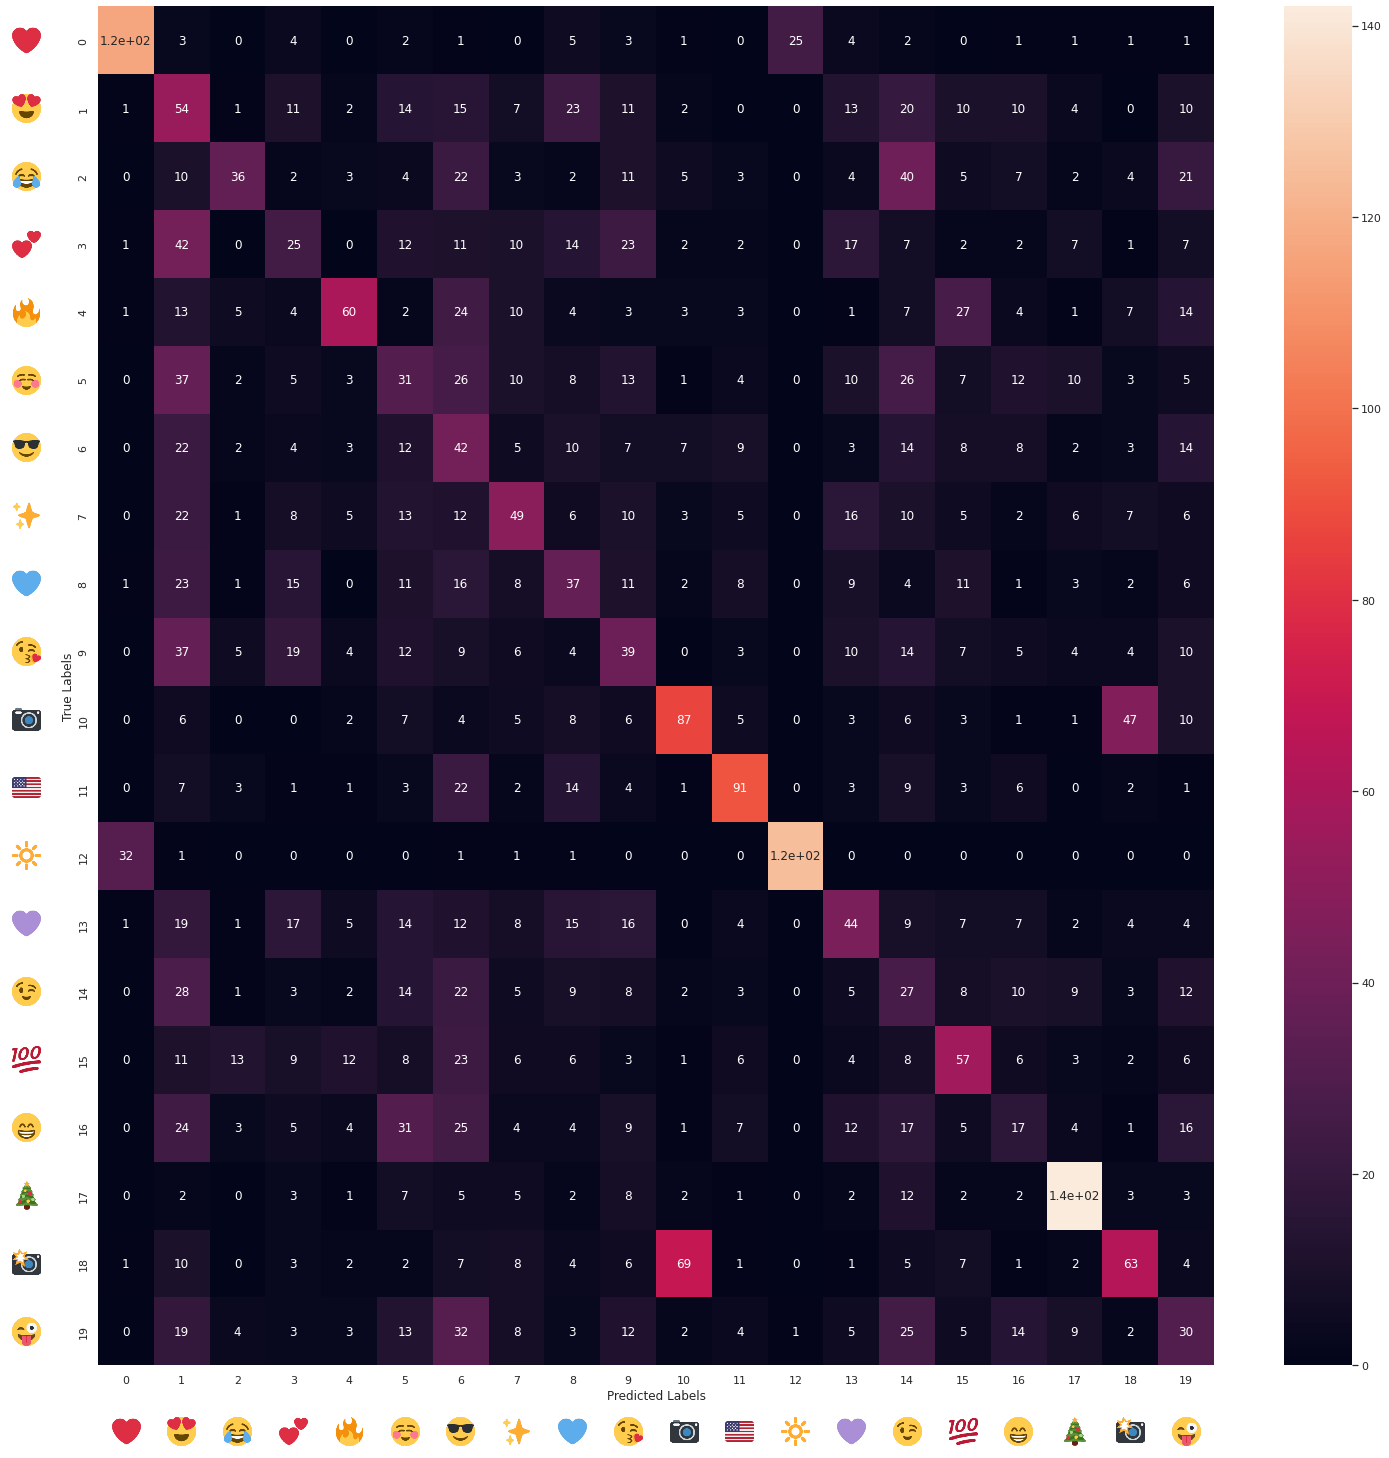

In [26]:
i=250
evaluate_predictions(i=i)

We calculate the precision for prediction the right emoji. 
    The following number show the percentage of correctly predicted (TP) 
    compared to wrongly + correctly predcted (FP + TP). 

Precision for the emoji with highest probability:
{'precision': 0.6019807280513919}


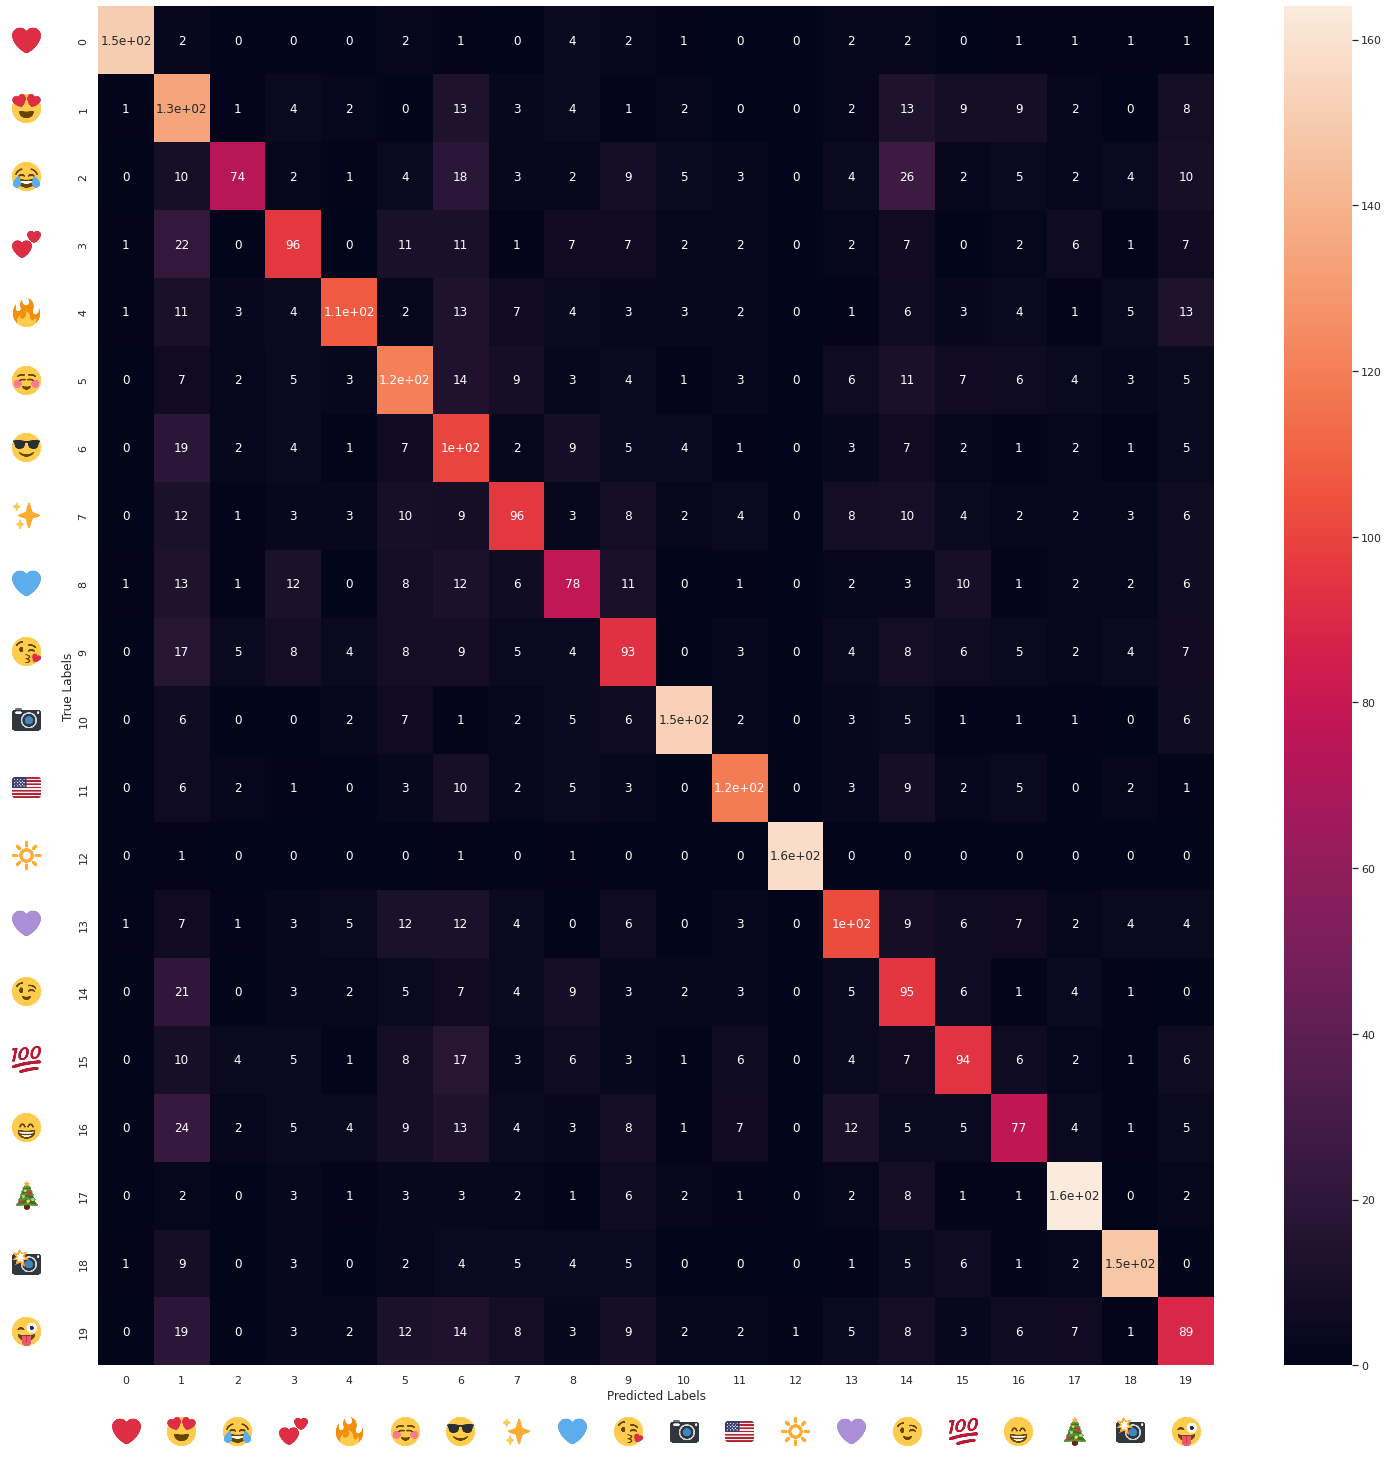

In [27]:
evaluate_suggestions(i=i)

We calculate the precision for prediction the right emoji. 
    The following number show the percentage of correctly predicted (TP) 
    compared to wrongly + correctly predcted (FP + TP). 

Precision for the emoji with highest probability:
{'precision': 0.3217344753747323}


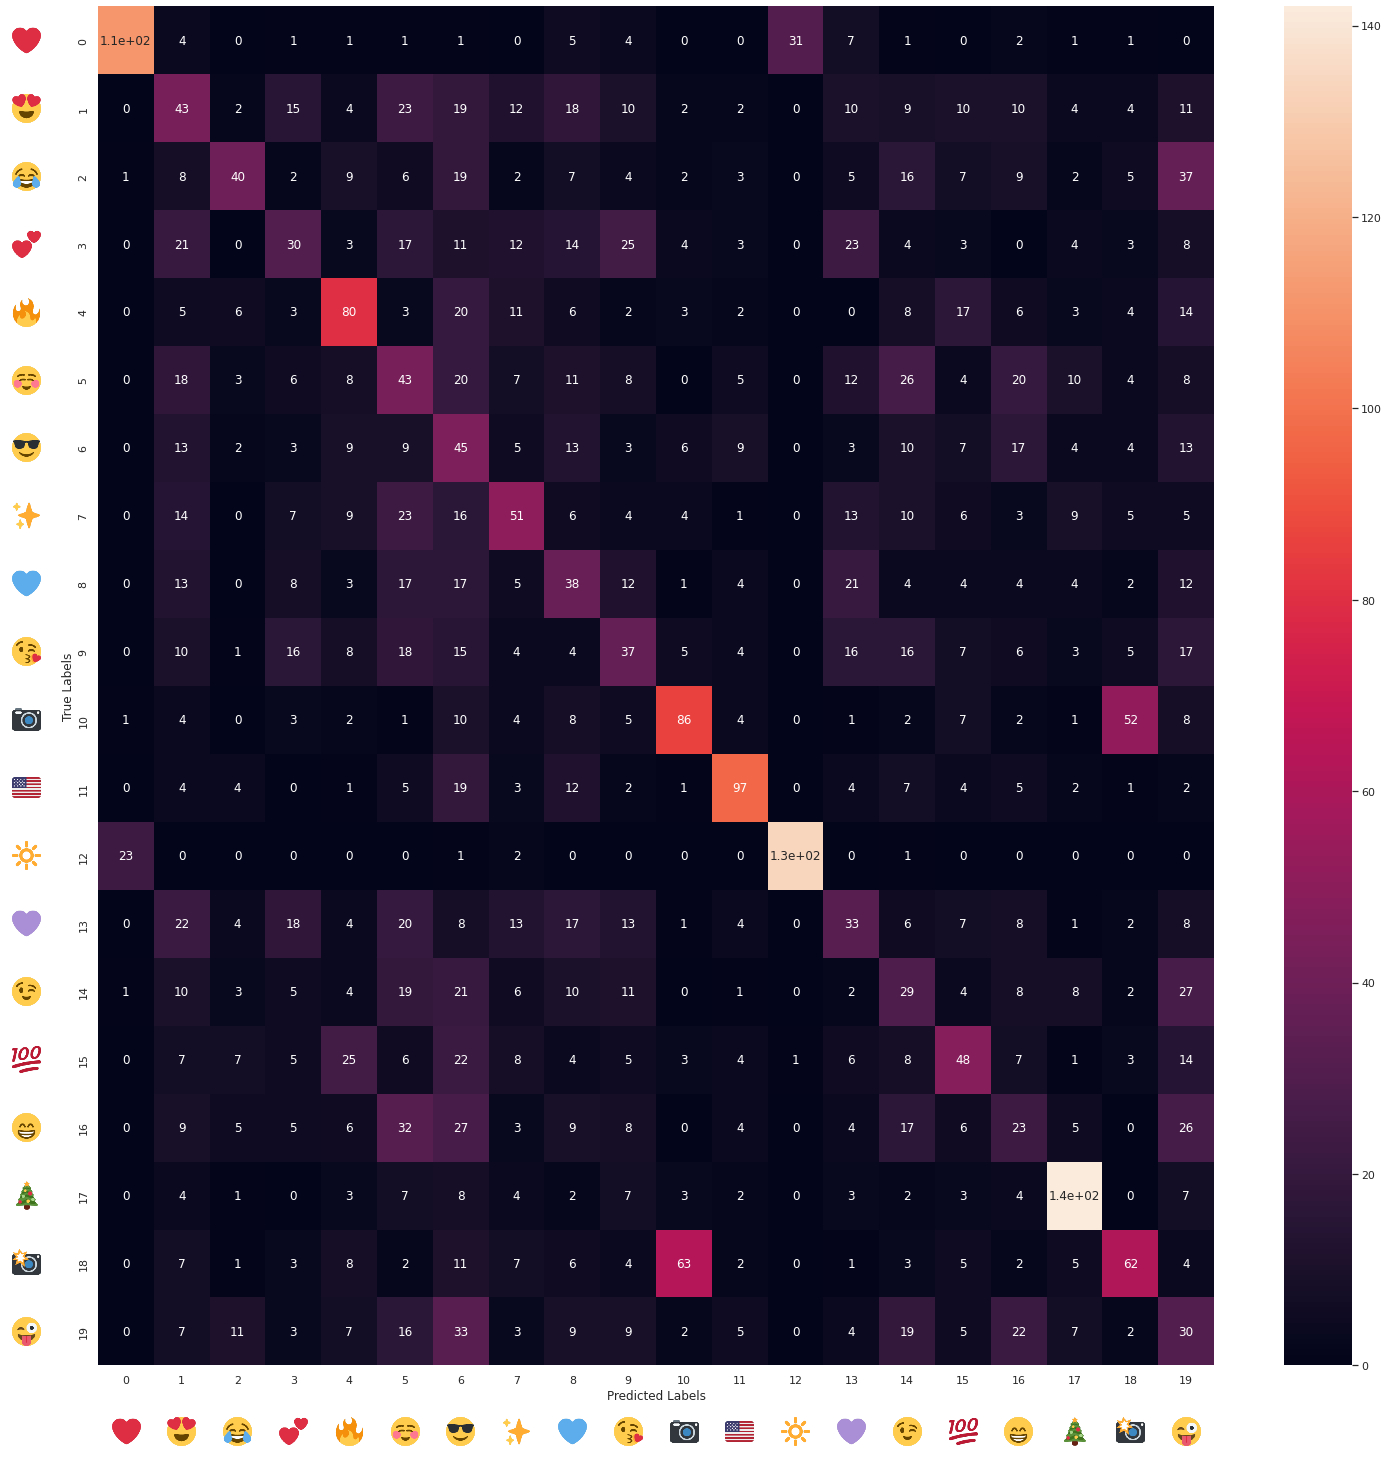

In [28]:
i=500
evaluate_predictions(i=i)

We calculate the precision for prediction the right emoji. 
    The following number show the percentage of correctly predicted (TP) 
    compared to wrongly + correctly predcted (FP + TP). 

Precision for the emoji with highest probability:
{'precision': 0.5990364025695931}


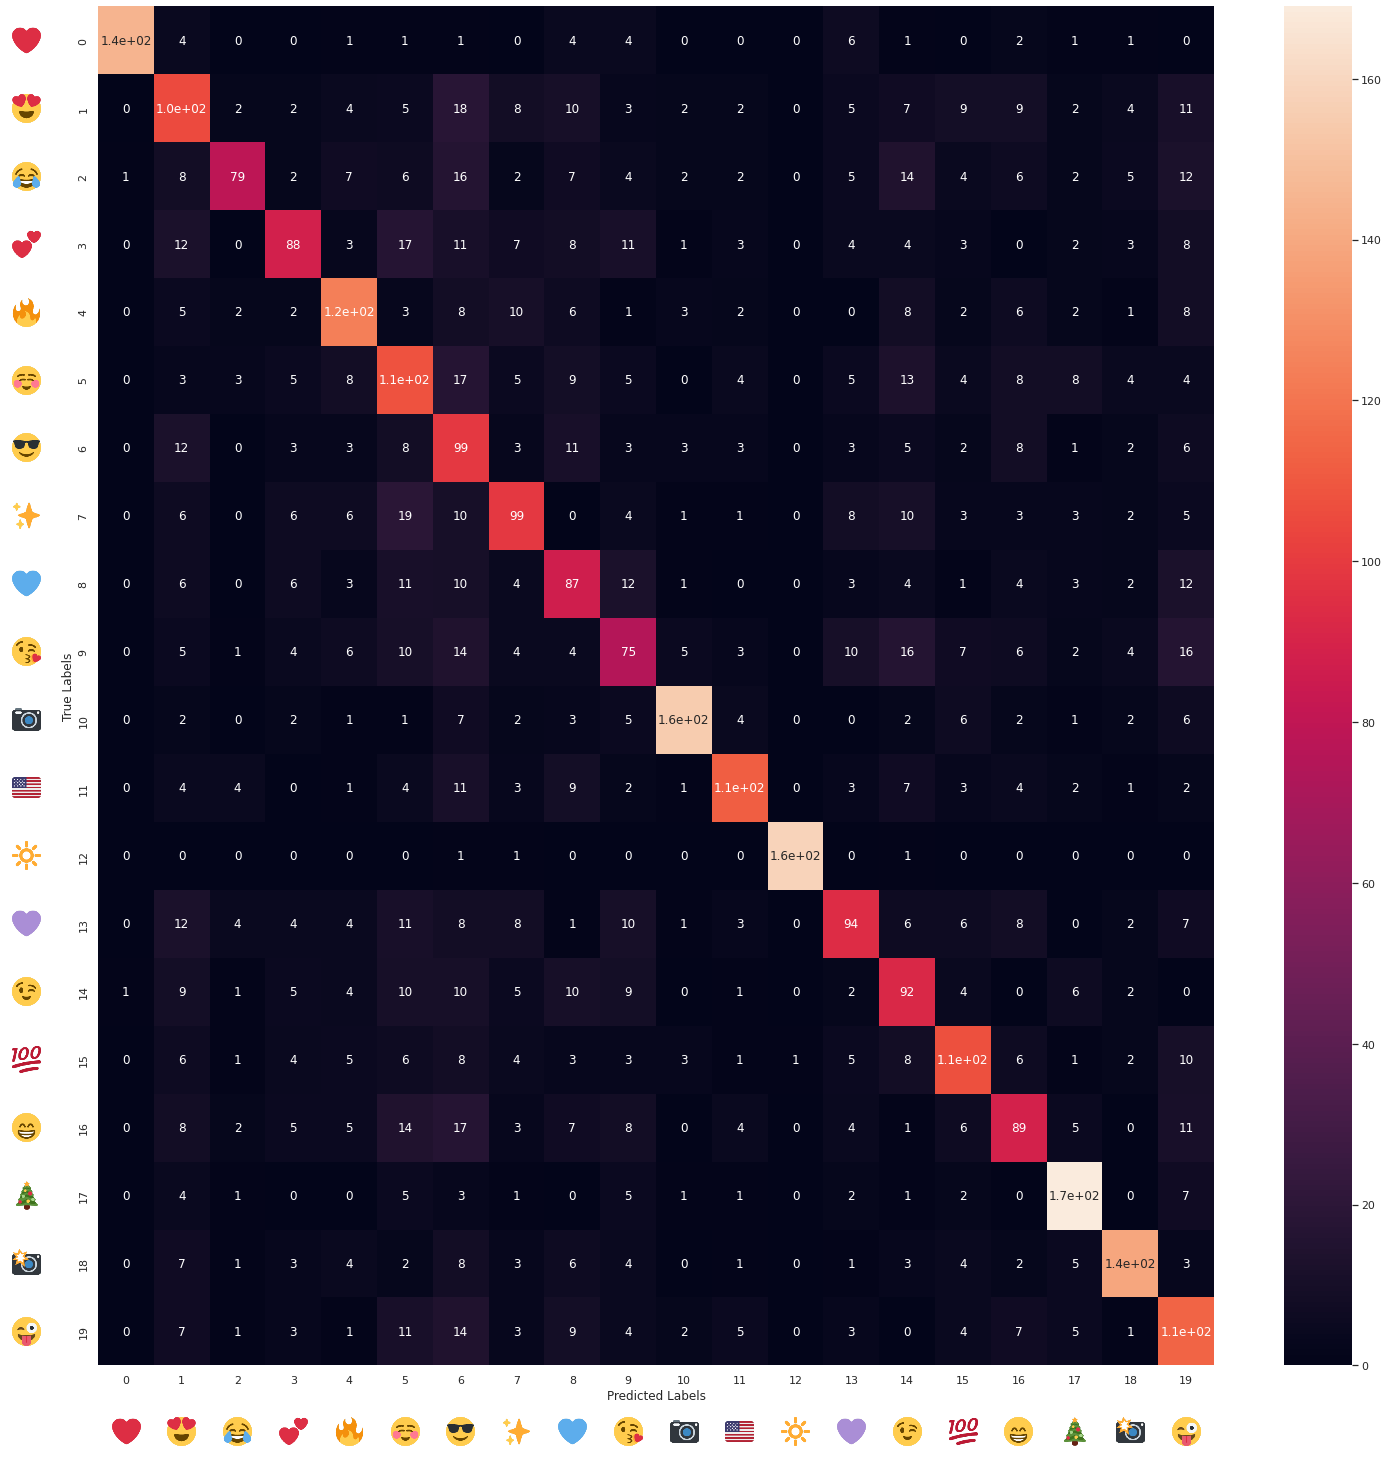

In [29]:
evaluate_suggestions(i=i)